In [1]:
# From NEW_dendro_cmz_higal, updated in Nov. 2024
# re-make Figure 1 for 3-D CMZ II paper with double colorbar and match colors throughout
# include code to make dendrogram mask file as well.
# Fixed python compatibility issues for re-submission to ApJ in Nov. 2024 

path='/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/FINAL_DATA_files_for_release/'
fig_path = '/Users/cab16109/Dropbox/Work/higal_cmz/PAPER/ALL_figures/'
path2='/Users/cab16109/Dropbox/Work/higal_cmz/nh2_pdfs/all_fits_files/'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS

from astropy.io import fits
from astropy.io.fits import getdata
from astrodendro import Dendrogram 

import aplpy

from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.colors import LogNorm

In [3]:
from astropy.table import Table
t = Table.read('/Users/cab16109/Dropbox/higal_cmz_dendro/column_and_temperature_and_luminosity_and_HCN_and_plfit_catalog_sourcename_flagged.ipac', 
               format='ipac')
t

_idx,area_ellipse,area_exact,average_column,major_sigma,mass,median_column,minor_sigma,peak_column,position_angle,radius,l_cen,b_cen,mean_tem,median_tem,peak_tem,HNCO_mom0,HC3N_fwhm,HNCO_fwhm,has_zone_outside_data,npix_cubes,HNCO_mom1,HCN_mom0,HC3N_mom0,HCN_fwhm,npix_total,HC3N_mom1,HCN_mom1,total_lum_no70_SFR,total_lum_no70,peak_lum,mean_lum,total_lum_SFR,total_lum,mean_lum_no70,peak_lum_no70,e_pl_alpha,pl_alpha,p_ks_powerlaw,Common_Name
,deg2,deg2,1 / cm2,pc,solMass,1 / cm2,pc,1 / cm2,deg,deg,,,K,K,K,K km / s,km / s,km / s,,,km / s,K km / s,K km / s,km / s,,km / s,km / s,solMass / yr,solLum,solLum,solLum,solMass / yr,solLum,solLum,solLum,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str27
0,0.0011,0.0035,4.6e+22,3.3,78000.0,3.3e+22,1.7,1.9e+23,81.0,0.016,0.55,-0.87,19.0,19.0,27.0,nan,nan,nan,True,0,nan,nan,nan,nan,339,nan,nan,0.00012,670000.0,10000.0,10000.0,0.00059,3400000.0,2000.0,15000.0,0.083,2.5,0.09,-
1,0.00013,0.00034,3.3e+22,1.3,5500.0,2.9e+22,0.51,9.9e+22,120.0,0.0054,360.0,-0.77,9.2,9.3,12.0,nan,nan,nan,True,0,nan,nan,nan,nan,33,nan,nan,7.3e-08,420.0,10000.0,10000.0,5.7e-05,330000.0,13.0,31.0,0.81,4.3,0.67,-
2,0.00017,0.00054,3.6e+22,1.3,9600.0,3e+22,0.67,8.3e+22,73.0,0.0062,0.089,-0.66,18.0,18.0,20.0,nan,nan,nan,True,0,nan,nan,nan,nan,53,nan,nan,5.3e-06,31000.0,10000.0,10000.0,9.2e-05,530000.0,580.0,1200.0,0.28,3.1,0.24,-
3,0.0025,0.0059,3.2e+22,5.0,93000.0,2.7e+22,2.5,9.7e+22,140.0,0.024,0.22,-0.49,17.0,16.0,25.0,nan,nan,nan,True,0,nan,nan,nan,nan,574,nan,nan,4e-05,230000.0,10000.0,3000.0,0.0003,1700000.0,400.0,3300.0,0.12,3.7,0.5,-
4,0.00051,0.0016,3.8e+22,1.8,30000.0,3e+22,1.4,9.7e+22,160.0,0.011,0.2,-0.52,16.0,16.0,18.0,nan,nan,nan,True,0,nan,nan,nan,nan,159,nan,nan,1e-05,60000.0,10000.0,7900.0,0.00022,1200000.0,370.0,830.0,0.19,3.4,0.17,-
5,0.0012,0.0029,3.4e+22,3.6,49000.0,3e+22,1.7,7.5e+22,180.0,0.017,0.24,-0.47,17.0,16.0,25.0,nan,nan,nan,True,0,nan,nan,nan,nan,284,nan,nan,2.2e-05,120000.0,5100.0,740.0,3.6e-05,210000.0,440.0,3300.0,0.17,3.9,0.21,-
6,0.0018,0.0058,4.5e+22,4.9,130000.0,3.8e+22,1.9,1.5e+23,45.0,0.02,1.7,-0.39,15.0,15.0,17.0,nan,nan,nan,True,0,nan,nan,nan,nan,564,nan,nan,2.9e-05,170000.0,10000.0,10000.0,0.00098,5600000.0,300.0,480.0,0.32,3.6,0.48,-
7,0.00023,0.00083,4.1e+22,1.2,16000.0,3.3e+22,0.95,9.8e+22,120.0,0.0073,360.0,-0.39,17.0,17.0,18.0,nan,nan,nan,True,0,nan,nan,nan,nan,81,nan,nan,7.3e-06,42000.0,10000.0,10000.0,0.00014,810000.0,520.0,1600.0,0.19,3.4,0.11,-


In [4]:
data, header = getdata(path+'higalcmz_column_density_source_only_inner7deg.fits', header=True)
wcs = WCS(header)

d = Dendrogram.compute(data, wcs=wcs, min_value=2e22, min_delta=5e22, min_npix=10) 

d.save_to(path+'higalcmz_dendrogram.fits')

#d = Dendrogram.load_from(path+'higalcmz_dendrogram.fits')


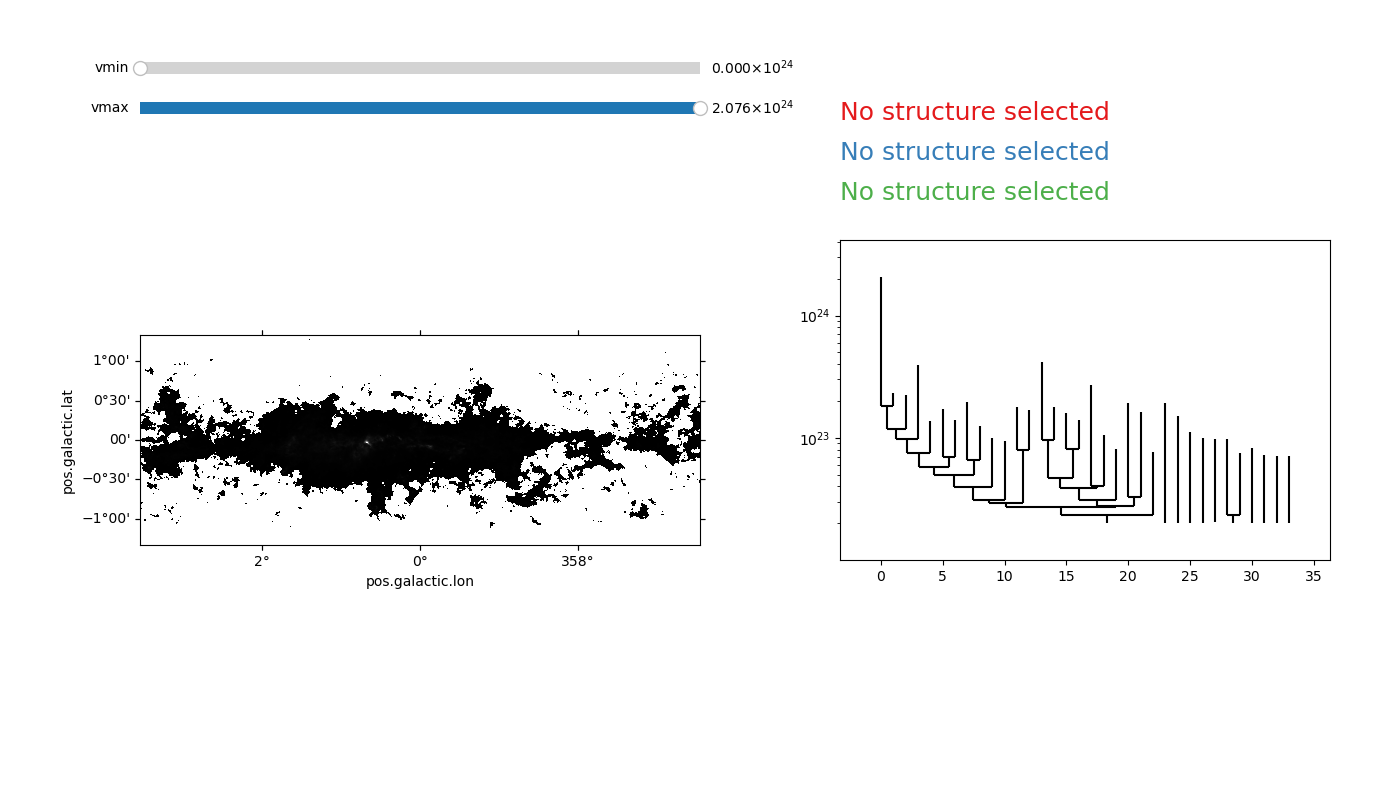

In [5]:
%matplotlib widget
v = d.viewer()
v.show()

In [6]:
# Make regular mask file. Fits file has 0s where no mask is present and the id of the highest structure
# if there is a dendrogram structure.

# open data file
hdu = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0]

#initiate full mask array with zeros
mask = np.zeros(hdu.data.shape, dtype=float)

#for struc in d.all_structures: #can't do it this way since trick below relies on idx increasing linearly.

# Create an array of indexes (56 here)
idx = np.linspace(1, 56, 56,dtype=int) 

for i in idx:
    # get structure
    struc = d[i]
    
    # get structure mask
    mask_s = struc.get_mask()

    # convert to float, and 0s (no mask) and 
    mask_val = mask_s.astype(np.float32)
    mask_val[np.where(mask_val==True)] = struc.idx
    mask_val[np.where(mask_val==False)] = 0.0

    # stupid (or smart?) way to add mask to array. if conflict, take higher idx
    mask+=mask_val
    mask[np.where(mask > struc.idx)] = struc.idx 

mask_hdu = fits.PrimaryHDU(mask.astype('short'), hdu.header)
mask_hdu.writeto(path+'higalcmz_dendrogram_mask.fits', overwrite=True)



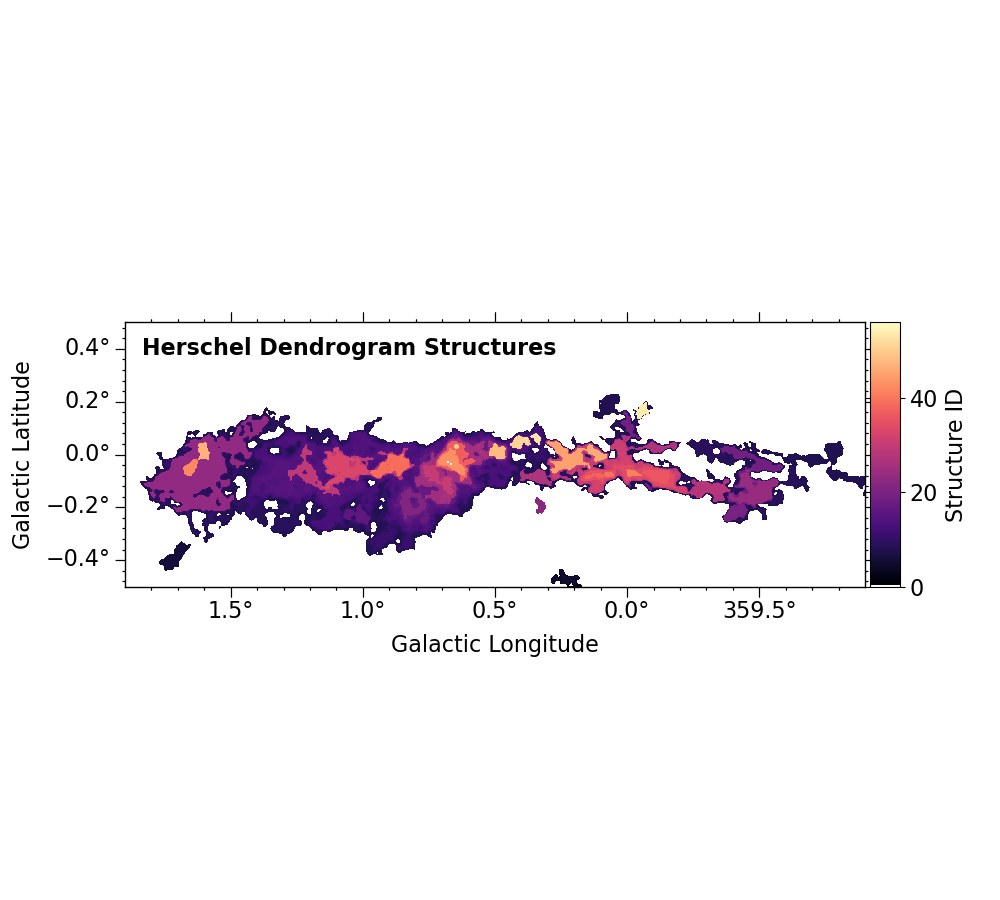

In [7]:
# Plot dendrogram
# this is good. 
%matplotlib widget

from matplotlib.colors import ListedColormap

# Get the original colormap
original_cmap = plt.get_cmap('magma')

# Create a new colormap based on the original one
new_cmap = ListedColormap(original_cmap.colors)

# Change the color at index 0 to white
new_cmap.colors[0] = 'white'

plt.rcParams.update({'font.size': 16}) #set fontsize
fig=aplpy.FITSFigure(path+'higalcmz_dendrogram_mask.fits')
fig.set_theme('publication')
fig.recenter(0.5,0.0, width=2.8, height=1.0)
fig.show_colorscale(cmap=new_cmap,vmin=0,vmax=56) #cmap='BuPu'
fig.add_colorbar()
fig.colorbar.set_width(0.3)
fig.colorbar.set_axis_label_text('Structure ID')

fig.tick_labels.set_xformat('ddd.d')
fig.tick_labels.set_yformat('ddd.d')

fig.add_label(1.05, 0.40, 'Herschel Dendrogram Structures', color='Black',weight='bold') #color='Purple'

plt.show()

plt.savefig(fig_path+'cmz_dendro.pdf',
            format='pdf', dpi=300, bbox_inches='tight')



In [8]:
# make separate mask files for branches and leaves

# open data file
hdu = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0]

leaves_idx = [leaf.idx for leaf in d.leaves]
# Need to order leaf and branch indexes from smallest to largest for silly code below to work
sorted_leaves_idx = np.sort(leaves_idx)

### LEAVES
#initiate full mask array with zeros
mask = np.zeros(hdu.data.shape, dtype=float)

for i in sorted_leaves_idx:    
    # get structure
    struc = d[i]
    
    # get structure mask
    mask_s = struc.get_mask()

    # convert to float, and 0s (no mask) and 
    mask_val = mask_s.astype(np.float32)
    mask_val[np.where(mask_val==True)] = struc.idx
    mask_val[np.where(mask_val==False)] = 0.0

    # stupid (or smart?) way to add mask to array. if conflict, take higher idx
    mask+=mask_val
    mask[np.where(mask > struc.idx)] = struc.idx 

mask_hdu = fits.PrimaryHDU(mask.astype('short'), hdu.header)
mask_hdu.writeto(path+'higalcmz_dendrogram_leaf_mask.fits', overwrite=True)


### BRANCHES
#initiate full mask array with zeros
mask = np.zeros(hdu.data.shape, dtype=float)

# Branch index array
branches_idx = [branch.idx for branch in d.all_structures if branch.is_branch]
# Need to order leaf and branch indexes from smallest to largest for silly code below to work
sorted_branches_idx = np.sort(branches_idx)

for i in sorted_branches_idx: 
    # get structure
    struc = d[i]
    
    # get structure mask
    mask_s = struc.get_mask()

    # convert to float, and 0s (no mask) and 
    mask_val = mask_s.astype(np.float32)
    mask_val[np.where(mask_val==True)] = struc.idx
    mask_val[np.where(mask_val==False)] = 0.0

    # stupid (or smart?) way to add mask to array. if conflict, take higher idx
    mask+=mask_val
    mask[np.where(mask > struc.idx)] = struc.idx 

mask_hdu = fits.PrimaryHDU(mask.astype('short'), hdu.header)
mask_hdu.writeto(path+'higalcmz_dendrogram_branch_mask.fits', overwrite=True)




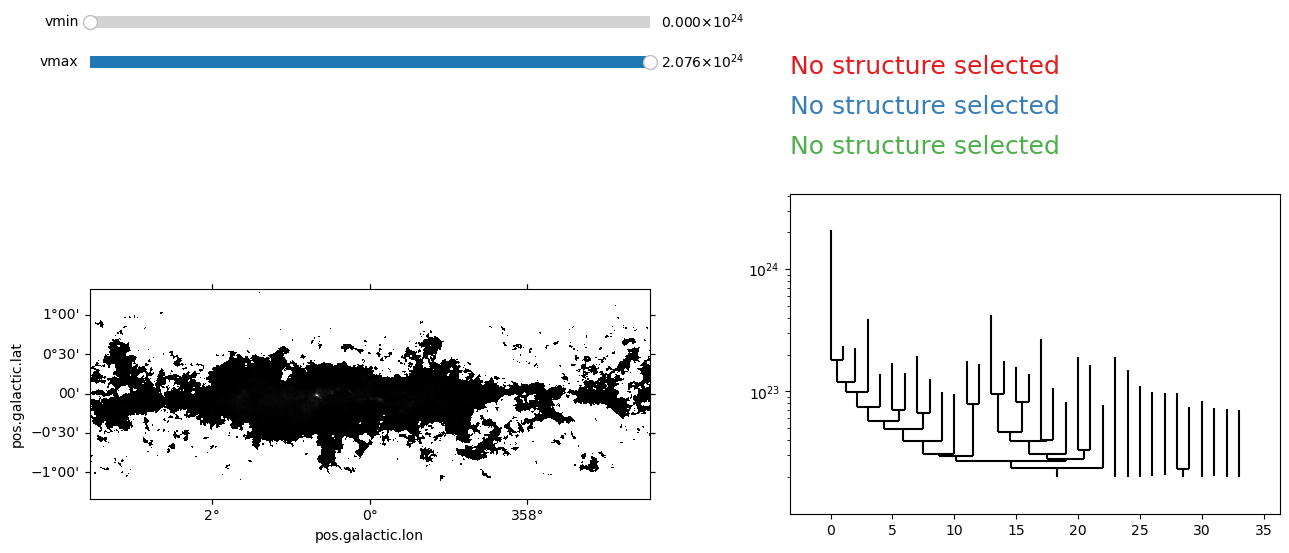

<Figure size 1000x900 with 0 Axes>

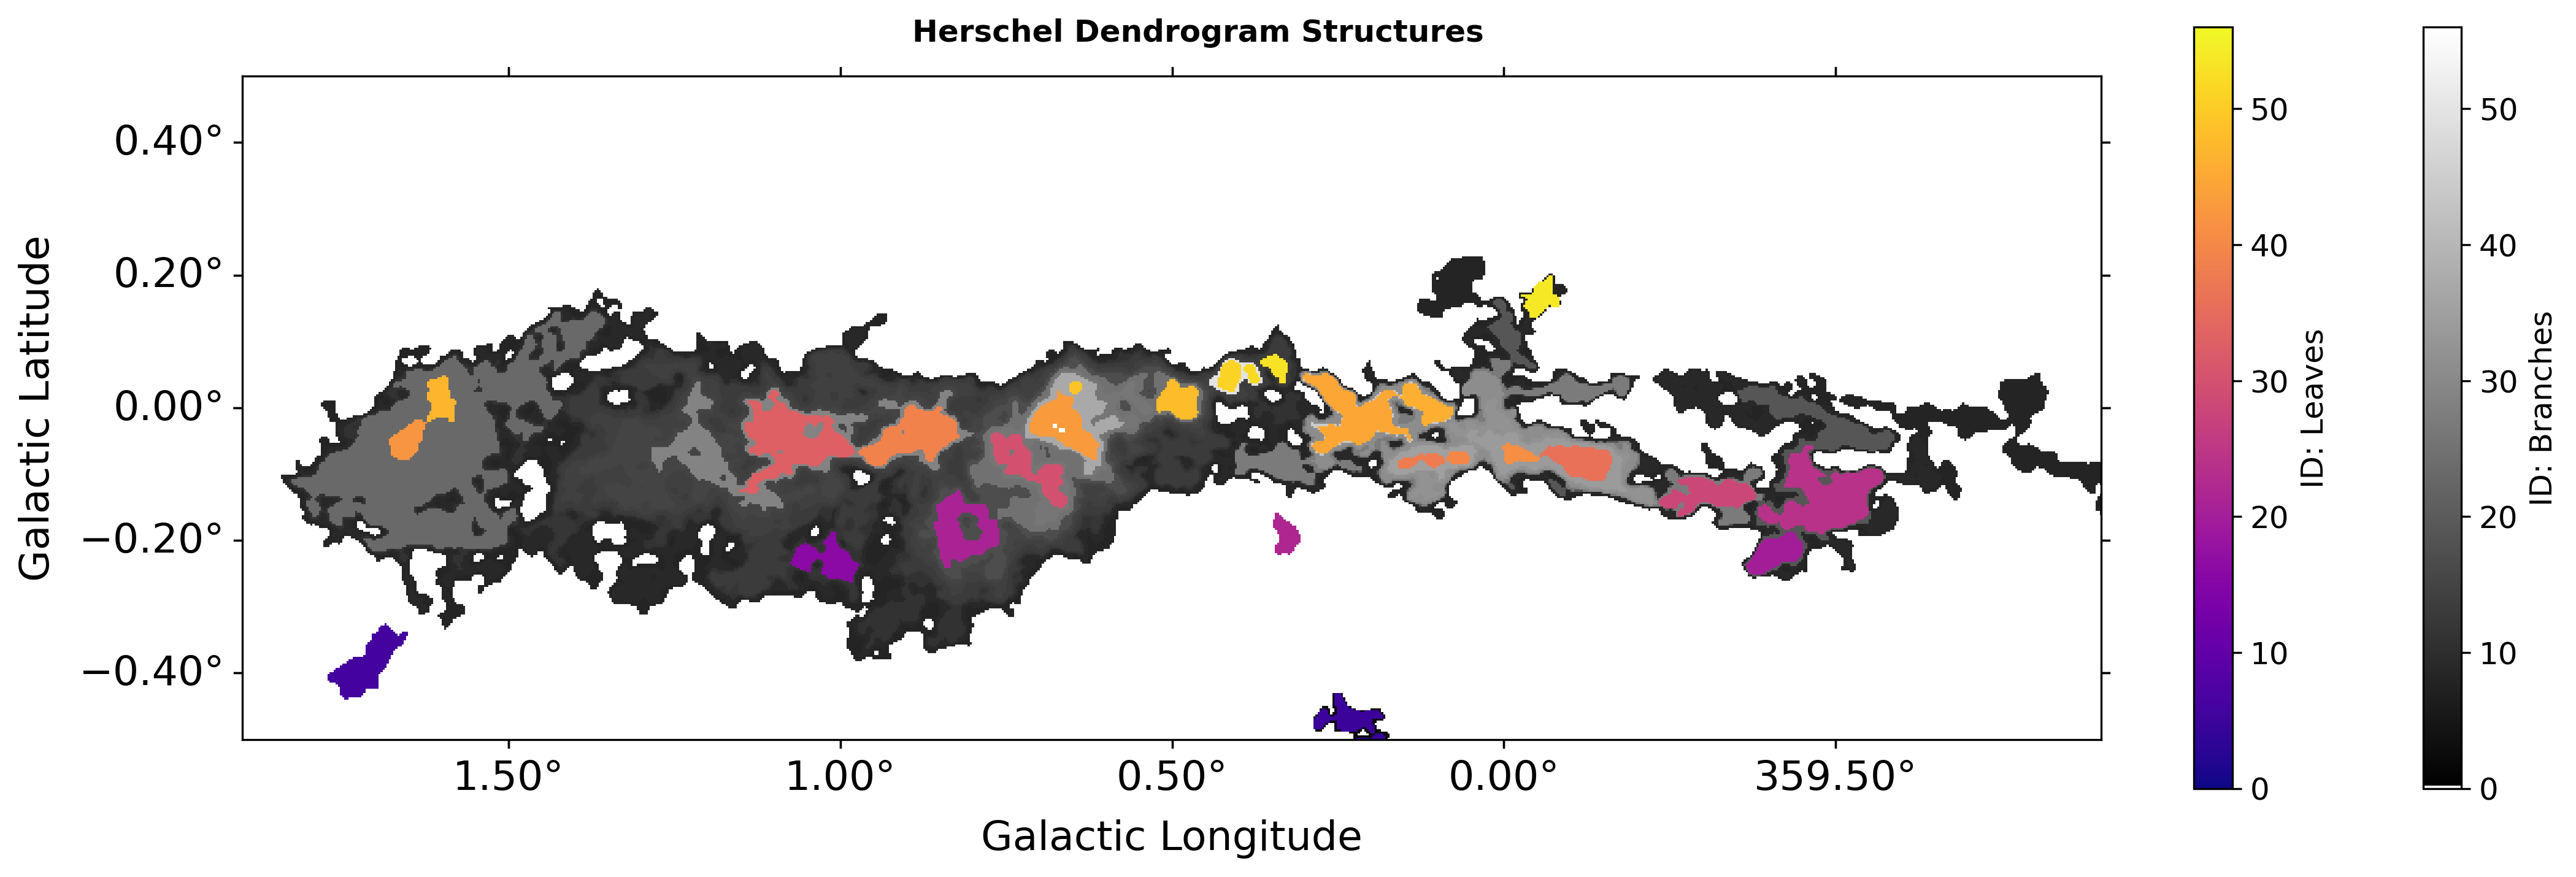

In [9]:
# Plot dendrogram two colorbar with aplpy
# this looks good!
%matplotlib inline
plt.clf()

from matplotlib.colors import ListedColormap
# Create a new colormap based on 'gray'
gray = plt.get_cmap('gray', 256)
newcolors = gray(np.linspace(0, 1, 256))
# Change the color at index 0 (bottom) to white
newcolors[0] = [1, 1, 1, 1] 
# Create the new colormap
new_cmap = ListedColormap(newcolors)

# Open mask files, get wcs
leaf_file = fits.open(path+'higalcmz_dendrogram_leaf_mask.fits')[0]
leaf_mask = leaf_file.data
branch_file = fits.open(path+'higalcmz_dendrogram_branch_mask.fits')[0]
branch_mask = branch_file.data

# Make leaf 0s into NaNs so it doesn't destroy background branches, but need to first make array a float
leaf_mask = leaf_mask.astype(float)
leaf_mask[leaf_mask == 0.0] = np.nan

# Initiate plot
fig, ax = plt.subplots(ncols= 1, subplot_kw={'projection': wcs}, figsize = (14,5), dpi = 300, layout='constrained')
plt.rcParams.update({'font.size': 12}) #set fontsize

# Plot the two images
im1 = ax.imshow(branch_mask, interpolation='nearest', cmap=new_cmap, vmin=0, vmax=56)
im2 = ax.imshow(leaf_mask, interpolation='nearest', cmap='plasma', vmin=0, vmax=56)
fig.text(0.35, 0.95, 'Herschel Dendrogram Structures', color='Black',weight='bold')

# Set plot size
ext_min = skycoord_to_pixel(SkyCoord(1.9, -0.5, unit="deg", frame='galactic'), wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.9, 0.5, unit="deg", frame='galactic'), wcs)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])

# Make coordinates pretty
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.set_ylabel('Galactic Latitude')
ax.set_xlabel('Galactic Longitude')

# Add colorbars
cbar1 = plt.colorbar(im1, ax=ax)
cbar2 = plt.colorbar(im2, ax=ax)
# Set colorbar labels
cbar1.set_label('ID: Branches')
cbar2.set_label('ID: Leaves')

plt.savefig(fig_path+'cmz_dendro_leaves_branches.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

##appearance of PDF (relative font sizes and label location) is different in the PDF ... 

<Figure size 640x480 with 0 Axes>

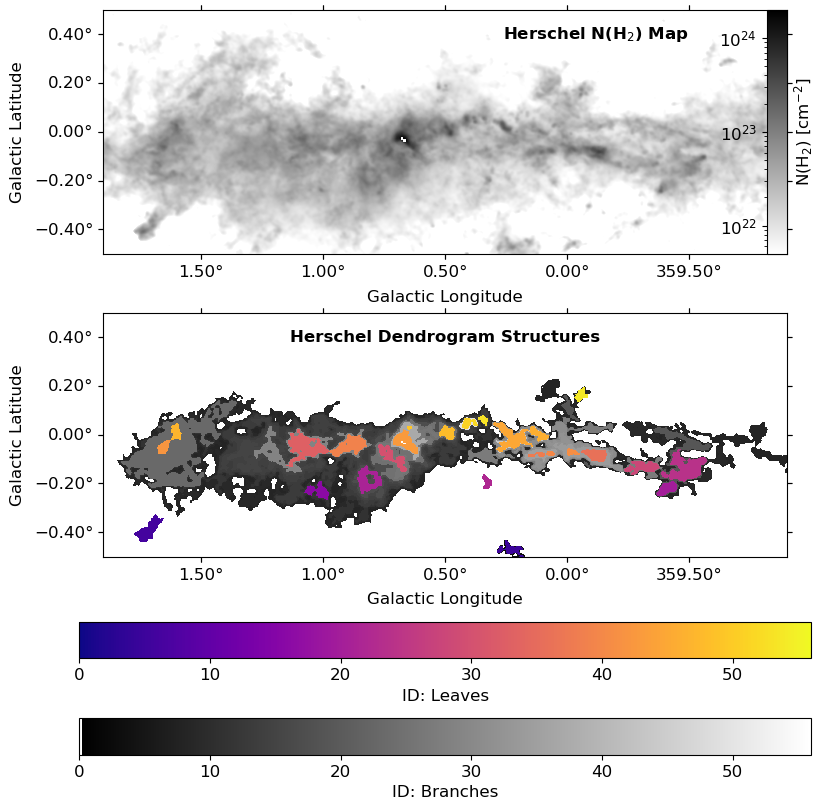

In [10]:
# Plot dendrogram two colorbar with aplpy
# Add in OG herschel image at the top!!! FOR FUN! Isn't this fun???
%matplotlib inline
plt.clf()

from matplotlib.colors import ListedColormap
# Create a new colormap based on 'gray'
gray = plt.get_cmap('gray', 256)
newcolors = gray(np.linspace(0, 1, 256))
# Change the color at index 0 (bottom) to white
newcolors[0] = [1, 1, 1, 1] 
# Create the new colormap
new_cmap = ListedColormap(newcolors)

# Open mask files, get wcs
leaf_file = fits.open(path+'higalcmz_dendrogram_leaf_mask.fits')[0]
leaf_mask = leaf_file.data
branch_file = fits.open(path+'higalcmz_dendrogram_branch_mask.fits')[0]
branch_mask = branch_file.data

# Make leaf 0s into NaNs so it doesn't destroy background branches, but need to first make array a float
leaf_mask = leaf_mask.astype(float)
leaf_mask[leaf_mask == 0.0] = np.nan

# Initiate plot
fig, ax = plt.subplots(nrows= 2, subplot_kw={'projection': wcs}, figsize = (20,8), layout='constrained', sharex=True)
plt.rcParams.update({'font.size': 12}) #set fontsize

ax0 = ax[0]
ax1 = ax[1]

# Axis 0 - NH2 map:
#just column density map
im0 = ax0.imshow(hdu.data, cmap='gray_r', norm=LogNorm(vmin=5e+21,vmax=2e+24))
ax0.text(0.72, 0.9, 'Herschel N(H$_2$) Map', color='Black',ha='center', va='center', transform=ax0.transAxes,fontweight='bold')

# Make coordinates pretty
lon = ax0.coords[0]
lat = ax0.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax0.set_ylabel('Galactic Latitude')
ax0.set_xlabel('Galactic Longitude')

# Set plot size
ext_min = skycoord_to_pixel(SkyCoord(1.9, -0.5, unit="deg", frame='galactic'), wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.9, 0.5, unit="deg", frame='galactic'), wcs)
ax0.set_xlim(ext_min[0],ext_max[0])
ax0.set_ylim(ext_min[1],ext_max[1])
#ax0.set_xticklabels([])  # Remove x-axis labels

# Add colorbars
#cbar0 = plt.colorbar(im0, ax=ax0)
#cbar0.set_label('N(H$_2$) [cm$^{-2}$]')
# Create an inset axes for the colorbar
axins = ax0.inset_axes([0.97, 0, 0.03, 1]) 
# [x0, y0, width, height]
# Add the colorbar to the inset axes
cbar0 = fig.colorbar(im0, cax=axins)
cbar0.ax.tick_params(left=True, right=False, labelleft=True, labelright=False)
axins.yaxis.set_ticks_position('left')
cbar0.set_label('N(H$_2$) [cm$^{-2}$]')

# Axis 1 - dendrogram masks
# Plot the two dendrogram masks
im1 = ax1.imshow(branch_mask, interpolation='nearest', cmap=new_cmap, vmin=0, vmax=56)
im2 = ax1.imshow(leaf_mask, interpolation='nearest', cmap='plasma', vmin=0, vmax=56)
ax1.text(0.5, 0.9, 'Herschel Dendrogram Structures', color='Black',ha='center', va='center', transform=ax1.transAxes,fontweight='bold')

# Set plot size
ax1.set_xlim(ext_min[0],ext_max[0])
ax1.set_ylim(ext_min[1],ext_max[1])

# Make coordinates pretty
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax1.set_ylabel('Galactic Latitude')
ax1.set_xlabel('Galactic Longitude')

# Add colorbars
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal')
cbar2 = plt.colorbar(im2, ax=ax1, orientation='horizontal')
# Set colorbar labels
cbar1.set_label('ID: Branches', fontsize=12)
cbar2.set_label('ID: Leaves', fontsize=12)

# Save plot
plt.savefig(fig_path+'cmz_dendro_leaves_branches_with_nh2.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
## Highlight two specific structures

hdu = fits.open(path+'higalcmz_column_density_source_only_inner7deg.fits')[0]
#choose two specifc structures to highlight
# Find the structures
structure_36 = d[36]

# Extract the masks
mask_36 = structure_36.get_mask()

# Create FITS HDU objects to contain the masks
mask_hdu_36 = fits.PrimaryHDU(mask_36.astype('short'), hdu.header)
mask_hdu_36.writeto(path+'mask_hdu_36.fits', overwrite=True)

structure_46 = d[46]

# Extract the masks
mask_46 = structure_46.get_mask()

# Create FITS HDU objects to contain the masks
mask_hdu_46 = fits.PrimaryHDU(mask_46.astype('short'), hdu.header)
mask_hdu_46.writeto(path+'mask_hdu_46.fits', overwrite=True)

#choose colors to match the other colormaps, below code from branch diagram
array = np.linspace(0,1,57) # 0 to 1 for all indices
cmap_l=plt.colormaps['plasma']
cmap_leaf=cmap_l(array)
rgba_36 = cmap_leaf[36]
rgba_46 = cmap_leaf[46]


In [12]:
# close all previous figures
plt.close('all')

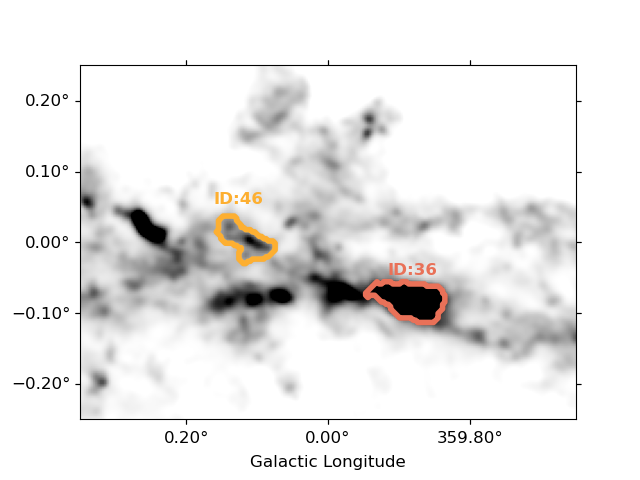

In [13]:
# Plot main image, with two clouds selected: Modified to have matching color bars
%matplotlib widget

# Initiate plot
#fig, ax = plt.subplots(nrows= 1, subplot_kw={'projection': wcs}, figsize = (12,5),layout='constrained')
fig, ax = plt.subplots(subplot_kw={'projection': wcs})
plt.rcParams.update({'font.size': 16}) #set fontsize

#just column density map
im = ax.imshow(hdu.data, cmap='gray_r', vmin=1e22,vmax=1e+23)

# Make coordinates pretty
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.set_ylabel('Galactic Latitude')
ax.set_xlabel('Galactic Longitude')

# Set plot size
ext_min = skycoord_to_pixel(SkyCoord(0.35, -0.25, unit="deg", frame='galactic'), wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.35, 0.25, unit="deg", frame='galactic'), wcs)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])

# Get mask data and overplot as contours
mask36 = getdata(path+'mask_hdu_36.fits')
mask46 = getdata(path+'mask_hdu_46.fits')
ax.contour(mask36, levels=[0], colors=[rgba_36], linewidths=4)
ax.contour(mask46, levels=[0], colors=[rgba_46], linewidths=4)

# Add structure labels
ax.text(0.67,0.42, 'ID:36', color=rgba_36, ha='center', va='center', transform=ax.transAxes, fontsize=12, fontweight='bold')
ax.text(0.32,0.62, 'ID:46', color=rgba_46, ha='center', va='center', transform=ax.transAxes, fontsize=12, fontweight='bold')

#plt.show()
plt.savefig(fig_path+'cmz_dendro_colors.pdf', format='pdf', bbox_inches='tight')


In [14]:
# get spectral data out of fits files
hdulist46=fits.open(path2+'HC3N_spectrum_idx46.fits')
hdu46=hdulist46[0]
targ46=hdulist46[0].data

hdulist36=fits.open(path2+'HC3N_spectrum_idx36.fits')
hdu36=hdulist36[0]
targ36=hdulist36[0].data

arr=np.arange(targ36.size)
h=hdulist36[0].header
print(h)
vel=h['CRVAL1']+(arr-h['CRPIX1'])*h['CDELT1']
vel=vel/1e3 #km/s
#print(vel)


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    1 / number of array dimensions                     NAXIS1  =                  339                                                  WCSAXES =                    1 / Number of coordinate axes                      CRPIX1  =                170.0 / Pixel coordinate of reference point            CDELT1  =        1776.20482459 / [m/s] Coordinate increment at reference point  CUNIT1  = 'm/s'                / Units of coordinate increment and value        CTYPE1  = 'VOPT'               / Optical velocity (linear)                      CRVAL1  =        135.452824627 / [m/s] Coordinate value at reference point      LONPOLE =                180.0 / [deg] Native longitude of celestial pole       LATPOLE =                  0.0 / [deg] Native latitude of celestial pole        RESTFRQ =        90978989000.0 / [Hz] Li

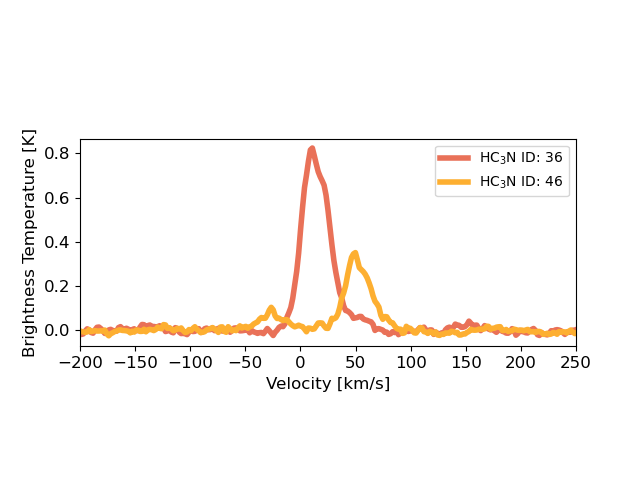

In [15]:
#plot spectrum of these sources
%matplotlib widget
# close all previous figures
plt.close('all')
plt.rcParams.update({'font.size': 12}) #set fontsize
fig,ax=plt.subplots()

ax.plot(vel, targ36, lw=4, color=rgba_36, label=r'HC$_3$N ID: 36')
ax.plot(vel, targ46, lw=4, color=rgba_46, label=r'HC$_3$N ID: 46')

ax.set_xlabel('Velocity [km/s]')
ax.set_ylabel(r'Brightness Temperature [K]')
ax.set_xlim([-200,250])
ax.set_aspect(200) # tuned by hand to try to get it to look nice

legend = plt.legend(loc='upper right', shadow=False, fontsize=10)

plt.savefig(fig_path+'spectra_46_36.pdf', format='pdf', dpi=100)
plt.show()

In [ ]:
### You don't need trunks, leaves and branches have it all! # uncomment single # below to see for yourself.

###Code to make a list of all the IDs of the leaves:
#leaves_idx = [leaf.idx for leaf in d.leaves]
###Code to make a list of all the IDs of branches:
#branches_idx = [branch.idx for branch in d.all_structures if branch.is_branch]
###To find trunk IDs (trunks_idx):
#trunks = [structure for structure in d.all_structures if structure.parent is None]
#trunks_idx = [structure.idx for structure in trunks]

#print(len(leaves_idx), len(branches_idx), len(trunks_idx), 'sum of b and l', (len(leaves_idx)+len(branches_idx)))

/var/folders/vs/df3n8vxn7cx5___snbvnk_wm0000gp/T/ipykernel_49206/2602502243.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray = plt.cm.get_cmap('gray', 256)


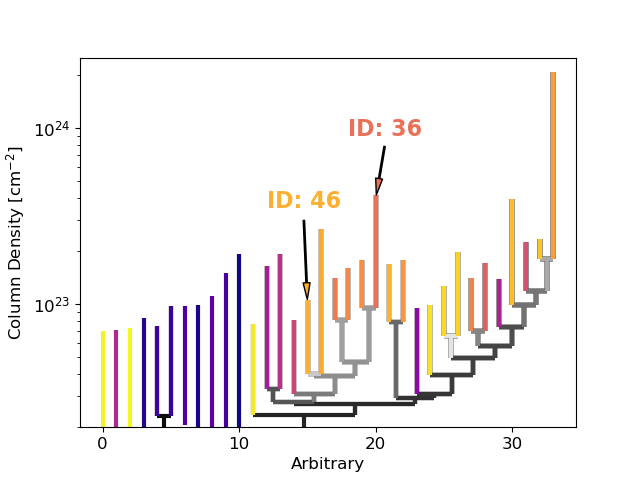

In [16]:
# Plot dendrogram hierarchy with NEW double colorbar (branches and leaves separate)
# as well as with 36 and 46 highlighted. 
%matplotlib widget
plt.clf()

# Colormap with white on bottom to match dendrogram mask above
from matplotlib.colors import ListedColormap
# Create a new colormap based on 'gray'
gray = plt.cm.get_cmap('gray', 256)
newcolors = gray(np.linspace(0, 1, 256))
# Change the color at index 0 (bottom) to white
newcolors[0] = [1, 1, 1, 1] 
# Create the new colormap
new_cmap = ListedColormap(newcolors)

# Initiate dendrogram plotter and plot parameters
p = d.plotter()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim([2e22, 2.5e24])
ax.set_yscale('log')
plt.rcParams.update({'font.size': 16}) #set fontsize

# Plot the whole tree
p.plot_tree(ax, color='black')

# identify leaf and branch IDs (don't need trunks, these contain all the structures)
leaves_idx = [leaf.idx for leaf in d.leaves]
branches_idx = [branch.idx for branch in d.all_structures if branch.is_branch]

# Create custom colomaps to match dendrogram mask figure
array = np.linspace(0,1,57) # 0 to 1 for all indices
cmap_branch=new_cmap(array)
cmap_l=plt.colormaps['plasma']
cmap_leaf=cmap_l(array)


# Highlight branches
for i in branches_idx:
    p.plot_tree(ax, [i], color=[cmap_branch[i]], lw=3)
    
# Highlight leaves
for i in leaves_idx:
    p.plot_tree(ax, [i], color=[cmap_leaf[i]], lw=3)

ax.set_xlabel("Arbitrary")
ax.set_ylabel("Column Density [cm$^{-2}$]")

plt.savefig(fig_path+'CMZ_full_dendro_tree_noannotation.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

#ax.text(20,6e23, 'ID: 36', color='black')
ax.annotate('ID: 36', xy=(20,4e23), xycoords='data', xytext=(18, 9e23),
            arrowprops=dict(facecolor=cmap_leaf[36], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=cmap_leaf[36])

ax.annotate('ID: 46', xy=(15,1e23), xycoords='data', xytext=(12, 3.5e23),
            arrowprops=dict(facecolor=cmap_leaf[46], width=1, headwidth=5, shrink=0.05), 
            fontsize=16, fontweight='bold',color=cmap_leaf[46])

plt.savefig(fig_path+'CMZ_full_dendro_tree_annotation.pdf',
            format='pdf', dpi=300, bbox_inches='tight')

